<h1 style="text-align:center;">Лабораторная работа №4</h1>

<h3 style="text-align:center;">Осипов Алексей Б01-204</h3>

**Цель**: решить задачу экстраполяции населения страны методами:

1. Классическая полиномиальная интерполяция по Ньютону 
2. Сплайн-интерполяция
3. Метод наименьших квадратов


В качестве исходных данных возьму население Китая с 1950 по 2000 года
| Год  | Население (чел) |
|------|-----------------|
| 1950 | 546 815 000     |
| 1960 | 667 070 000     |
| 1970 | 818 315 000     |
| 1980 | 981 235 000     |
| 1990 | 1 135 185 000   |
| 2000 | 1 262 645 000   |

In [122]:
import numpy as np
import math
import matplotlib.pyplot as plt
import copy

Буду использовать свой алгоритм Гаусса из второй лабы для решения СЛАУ. Это пригодится при построении кубического сплайна и МНК

In [125]:
# Вычисление 3й нормы вектора
def norm_3(U):
    r = 0
    for i in range(len(U)):
        r += U[i,0] * U[i,0]
        
    return np.sqrt(r)

# Поменять строки
def swap_rows(A, i, j):
    A[[i, j], :] = A[[j, i], :]

# Поменять столбцы
def swap_columns(A, i, j):
    A[:, [i, j]] = A[:, [j, i]]
    
#Функция для обмена значений
def swap(a,b):
    return b,a
    
# глобальный элемент А
def find_main_el(A, iter):
    size = A.shape[0]
    main_el = A[iter,iter]
    i_main = iter
    j_main = iter

    for i in range(size - iter): 
        for j in range(size - iter):
            if abs(A[i + iter,j + iter]) > abs(main_el):
                i_main = i + iter
                j_main = j + iter
                main_el = A[i_main,j_main]
    return [i_main, j_main]

def Gauss(a, f):
    
    A = copy.deepcopy(a)
    F = copy.deepcopy(f)
    
    size = len(A)  # размеры матрицы 
    
    X = np.arange(size) # Массив, чтобы запомнить порядок при смене строк и столбцов - пригодится в конце
    U  = np.ones((size, 1)) # массив решений
    result = np.ones((size, 1)) # Для ответа

    # Прямой ход
    for iter in range(size): 
        
        main_ind = find_main_el(A,iter) # Rоординаты главного элемента
        main_el = A[main_ind[0], main_ind[1]] # Сам главный элемент
        
        if(main_ind[0] - iter != 0): # Перестановка строк для главного элемента
            swap_rows(A[iter:, iter:], 0, main_ind[0] - iter)
            F[iter] = F[main_ind[0]] + F[iter]
            F[main_ind[0]] = F[iter] - F[main_ind[0]]
            F[iter] = F[iter] - F[main_ind[0]]
            
        if(main_ind[1] - iter != 0): # Перестановка столбцов для главного элемента
            swap_columns(A, iter, main_ind[1])
            # swap(X[iter], X[main_ind[1]])
            X[iter] = X[main_ind[1]] + X[iter]
            X[main_ind[1]] = X[iter] - X[main_ind[1]]
            X[iter] = X[iter] - X[main_ind[1]]
        
        A[iter:, iter:][0] =  A[iter:, iter:][0] / main_el
        F[iter] = F[iter] / main_el
        
        for i in range(size - iter - 1):
            F[iter + i + 1] -= (F[iter]  * A[iter:, iter:][i + 1][0])
            A[iter:, iter:][i + 1] -= (A[iter:, iter:][0] * A[iter:, iter:][i + 1][0])

    # Так как алгоритм не доходит до нижнего углового элемента, делаем его 1
    F[-1] /= A[-1, -1]
    A[size - 1, size - 1] = 1
    
    # Обратный ход
    for i in range(size-1, -1, -1):
        U[i] = F[i]
        for j in range(i + 1, size):
            U[i] -= U[j] * A[i][j]

    for i in range(size):
        result[int(X[i])][0] = U[i][0]

    return result

**1) Классическая полиномиальная интерполяция по Ньютону**

In [128]:
years = np.array([1950, 1960, 1970, 1980, 1990, 2000])
population = np.array([546815000, 667070000, 818315000, 981235000, 1135185000, 1262645000])

In [130]:
def divided_differences(years, population):  # Считаем разделённые разности
    n = len(population)
    div_diff = np.zeros((n, n))
    div_diff[:, 0] = population  # Первый столбец — значения функции

    for j in range(1, n):
        for i in range(n - j):
            div_diff[i, j] = (div_diff[i + 1, j - 1] - div_diff[i, j - 1]) / (years[i + j] - years[i])

    return div_diff[0]  # Верхняя строка - коэффициенты для интерполянта Ньютона

def newton_polynom(predict_point, years, div_diff):
    n = len(div_diff)
    val = div_diff[0]
    for i in range(1, n):
        p = div_diff[i]
        for j in range(i):
            p *= (predict_point - years[j])
        val += p
    return val

div_diff = divided_differences(years, population)

year_to_predict = 2010
predicted_population = newton_polynom(year_to_predict, years, div_diff)
print(f"Население на {year_to_predict} год = {round(predicted_population)} человек")

Население на 2010 год = 1353675000 человек


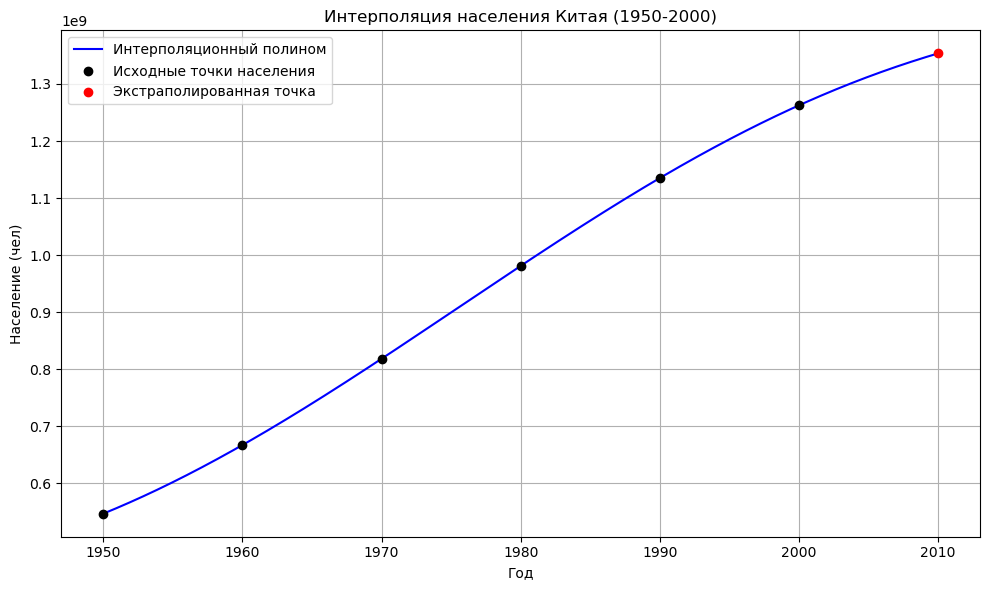

In [132]:

x_years = np.linspace(1950, 2010, 500)
y = [newton_polynom(x, years, div_diff) for x in x_years]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(x_years, y, label="Интерполяционный полином", color="blue")
plt.scatter(years, population, color="black", label="Исходные точки населения", zorder=2)
plt.scatter(year_to_predict, predicted_population, color="red", label="Экстраполированная точка", zorder=2)
plt.title("Интерполяция населения Китая (1950-2000)")
plt.xlabel("Год")
plt.ylabel("Население (чел)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Как видно из графика, полином отлично предсказывает население Китая. По данным из википедии, население на 2010 год составило 1 337 705 000 человек, полином предсказал 1 353 675 000 человек 

Ради эксперимента продлим полином т.е. захватим большее количество лет и посмотрим на его вид

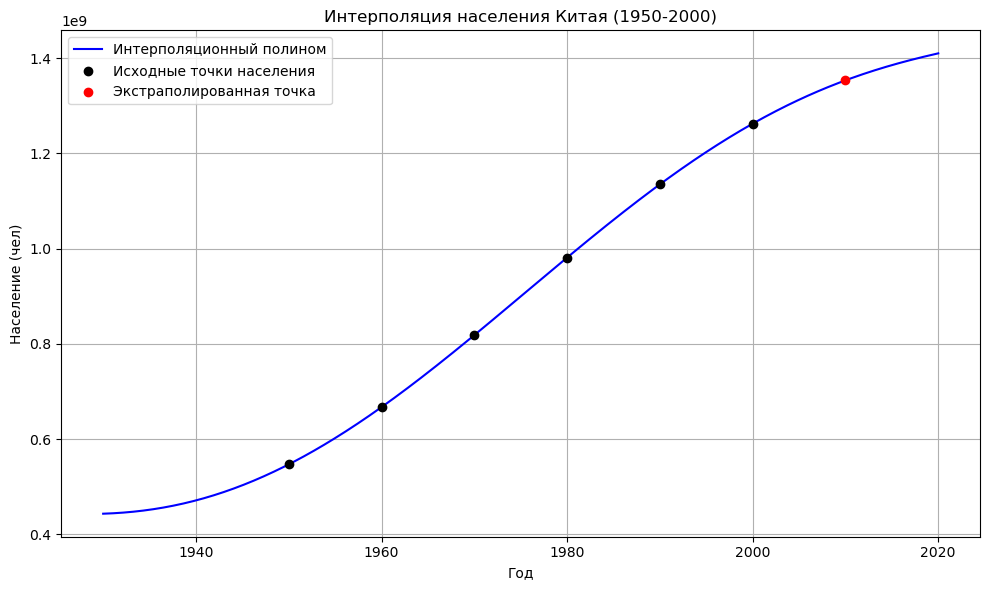

In [136]:
x_years = np.linspace(1930, 2020, 500)
y = [newton_polynom(x, years, div_diff) for x in x_years]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(x_years, y, label="Интерполяционный полином", color="blue")
plt.scatter(years, population, color="black", label="Исходные точки населения", zorder=2)
plt.scatter(year_to_predict, predicted_population, color="red", label="Экстраполированная точка", zorder=2)
plt.title("Интерполяция населения Китая (1950-2000)")
plt.xlabel("Год")
plt.ylabel("Население (чел)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Теперь если посмотреть население на 2020 год, то оно тоже окажется близко к реальному 😎

In [139]:
year_to_predict = 2020
predicted_population = newton_polynom(year_to_predict, years, div_diff)
print(f"Население на {year_to_predict} год = {round(predicted_population)} человек")

Население на 2020 год = 1410370000 человек


Посмотрим для примера насление за 1995 год, чтобы потом сравнить с остальными видами интерполяции и понять, какая лучше

In [142]:
year_to_predict = 1995
predicted_population = newton_polynom(year_to_predict, years, div_diff)
print(f"Население на {year_to_predict} год = {round(predicted_population)} человек")

Население на 1995 год = 1203077363 человек


**2) Сплайн - интерполяция**

In [145]:
years = np.array([1950, 1960, 1970, 1980, 1990, 2000])
population = np.array([546815000, 667070000, 818315000, 981235000, 1135185000, 1262645000])

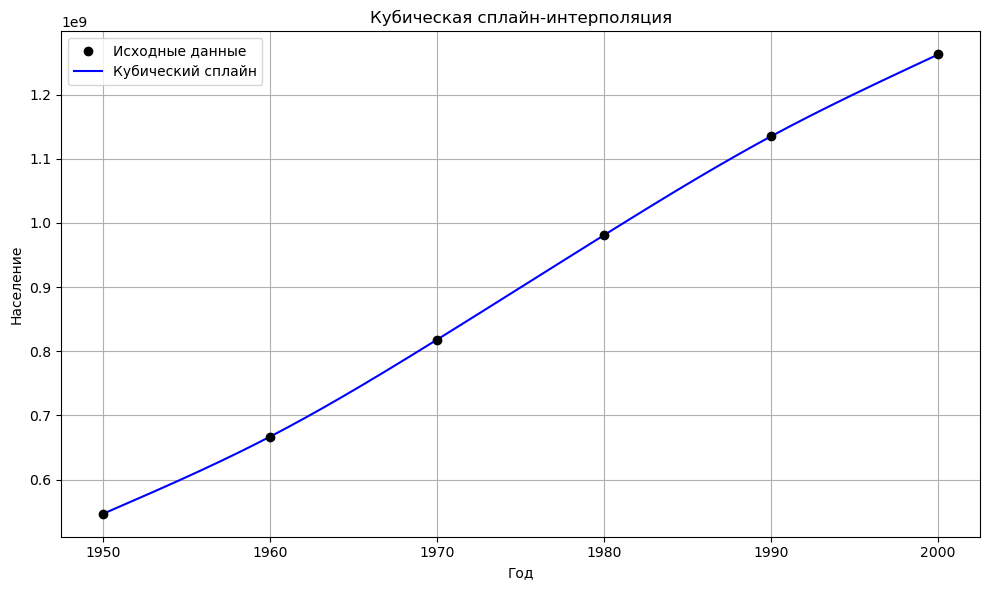

In [173]:
def spline(years, population):
    h = np.diff(years) # Можно было просто написать 10, т.к. в моём случае шаг одинаковый, но для общего случая так лучше
    
    # Составление матрицы и вектора правых частей для системы
    n = len(years) - 1
    A = np.zeros((n + 1, n + 1))
    B = np.zeros((n + 1, 1))
    
    # Условия на второй производной в краевых точках
    A[0, 0] = 1
    A[n, n] = 1
    
    # Заполнение матрицы для внутренних точек
    for i in range(1, n):
        A[i, i - 1] = h[i - 1]
        A[i, i] = 2 * (h[i - 1] + h[i])
        A[i, i + 1] = h[i]
        B[i] = 3 * ((population[i + 1] - population[i]) / h[i] - (population[i] - population[i - 1]) / h[i - 1])
    
    # Решение системы на коэффициенты c_k
    c = Gauss(A, B)
    
    # Вычисление коэффициентов b_k и d_k
    b = np.zeros(n)
    d = np.zeros(n)
    for i in range(n):
        b[i] = (population[i + 1] - population[i]) / h[i] - h[i] * (2 * c[i][0] + c[i + 1][0]) / 3
        d[i] = (c[i + 1][0] - c[i][0]) / (3 * h[i])
        
    return b, c, d

# Построение сплайна
b, c, d = spline(years, population)
x_fine = np.linspace(years[0], years[-1], 500)
y_fine = np.zeros_like(x_fine)
    
for i in range(len(years)-1):
    mask = (x_fine >= years[i]) & (x_fine <= years[i + 1]) # Переменная mask нужна для того, чтобы понять, лежат ли текущие точки 
    dx = x_fine[mask] - years[i]                           # в данном интервале или нет
    y_fine[mask] = (population[i] + b[i] * dx + c[i] * dx**2 + d[i] * dx**3) #dx - расстояние между текущими точками и левым концом интервала
        

plt.figure(figsize=(10, 6))
plt.scatter(years, population, color="black", label='Исходные данные', zorder=3)
plt.plot(x_fine, y_fine, color='blue', label='Кубический сплайн')
plt.xlabel('Год')
plt.ylabel('Население')
plt.title('Кубическая сплайн-интерполяция')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


Сравним население за 1995 год с тем же, только по экстраполяции Ньютоном

In [150]:
print(f"Население за 1995 год = {round(y_fine[450])} человек")

Население за 1995 год = 1202441354 человек


Вышло примерно столько же

Теперь попробуем экстраполировать кривую населения на 2010 год

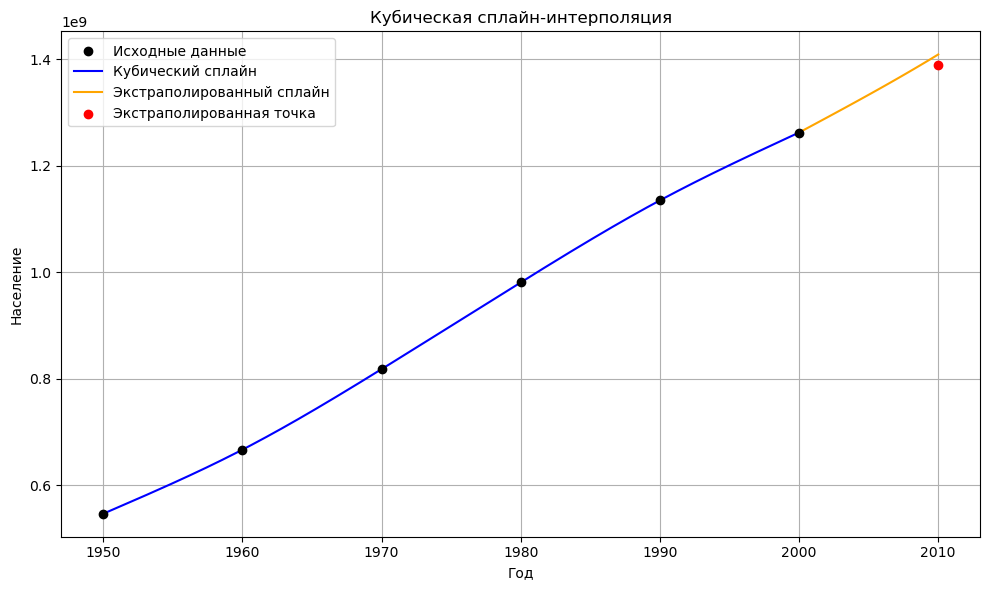

In [177]:
def extrapolate(x_ex, years, population, b, c, d):
    if x_ex < years[0]:  # Левая экстраполяция
        i = 0
        dx = x_ex - years[i]
        return (population[i]+ b[i] * dx+ c[i] * dx**2+ d[i] * dx**3)
    elif x_ex > years[-1]:  # Правая экстраполяция
        i = len(years) - 2
        dx = x_ex - years[i]
        return (population[i]+ b[i] * dx+ c[i] * dx**2+ d[i] * dx**3)
    else:
        raise ValueError("Точка внутри интервала")

year_to_extrapolate = 2010
population_2010 = extrapolate(year_to_extrapolate, years, population, b, c, d)

x_ex = np.linspace(years[-1], 2010, 100)  # Точки для графика экстраполяции
dx_ex = x_ex - years[-1]
y_ex = (population[-1]+ b[-1] * dx_ex+ c[-1] * dx_ex**2+ d[-1] * dx_ex**3)

plt.figure(figsize=(10, 6))
plt.scatter(years, population, color="black", label='Исходные данные', zorder=3)
plt.plot(x_fine, y_fine, color='blue', label='Кубический сплайн')
plt.plot(x_ex, y_ex, color='orange', label='Экстраполированный сплайн')
plt.scatter(year_to_extrapolate, population_2010, color='red', label='Экстраполированная точка', zorder=3)
plt.xlabel('Год')
plt.ylabel('Население')
plt.title('Кубическая сплайн-интерполяция')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [155]:
print("Экстраполированная точка =", int(population_2010.item()))
print("Экстраполированная точка из графика =", round(y_ex[-1]))

Экстраполированная точка = 1390105000
Экстраполированная точка из графика = 1409241555


В целом, экстраполированная точка близка к правде

**3) Метод наименьших квадратов**

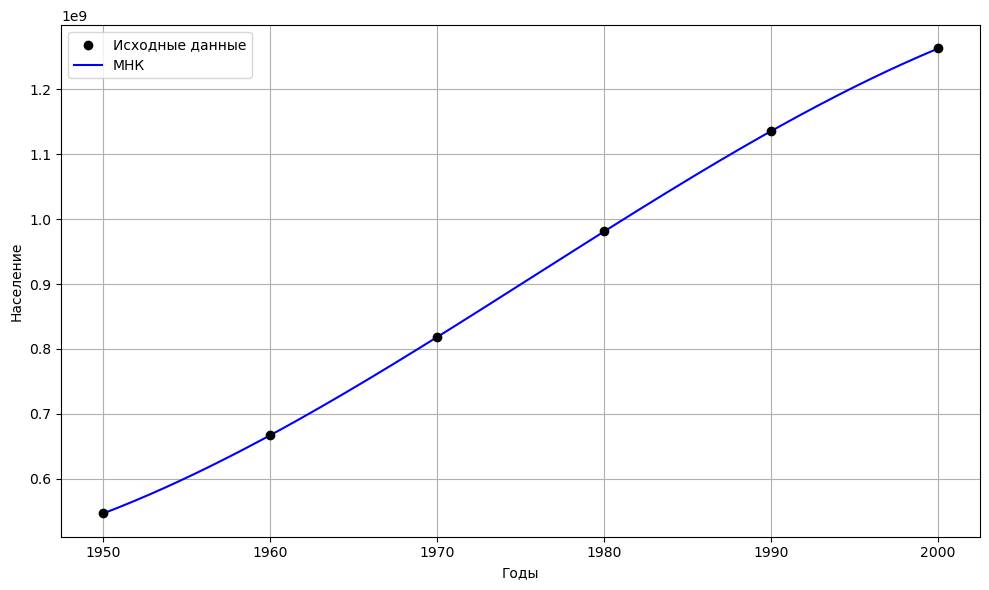

In [247]:
years_scaled = years - np.mean(years) # Тут я вычитаю среднее арифметическое из всех точек, иначе при решении СЛАУ на коэффициенты
                                      # получаются слишком большие числа, и программа падает

# Степень полинома
degree = 3

A = np.zeros((degree + 1, degree + 1))
b = np.zeros((degree + 1, 1))

for i in range(degree + 1):
    for j in range(degree + 1):
        A[i, j] = np.sum(years_scaled ** (i + j))
    b[i, 0] = np.sum(population * (years_scaled ** i))

coefficients = Gauss(A, b)

# Построение полинома
def polynomial(x, coeffs):
    return sum(c * (x ** i) for i, c in enumerate(coeffs))

x_vals = np.linspace(min(years_scaled), max(years_scaled), 500)
y_vals = polynomial(x_vals, coefficients)

x_original = x_vals + np.mean(years) # Добавляем среднее арифметическое обратно, чтобы на графике данные были в изначальном масштабе

plt.figure(figsize=(10, 6))
plt.scatter(years, population, color='black', label='Исходные данные', zorder=3)
plt.plot(x_original, y_vals, color='blue', label='МНК')
plt.xlabel('Годы')
plt.ylabel('Население')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Сравним население за 1995 год с остальными видами интерполяции

In [237]:
print(f"Население за 1995 год = {round(y_vals[450])} человек")

Население за 1995 год = 1204809159 человек


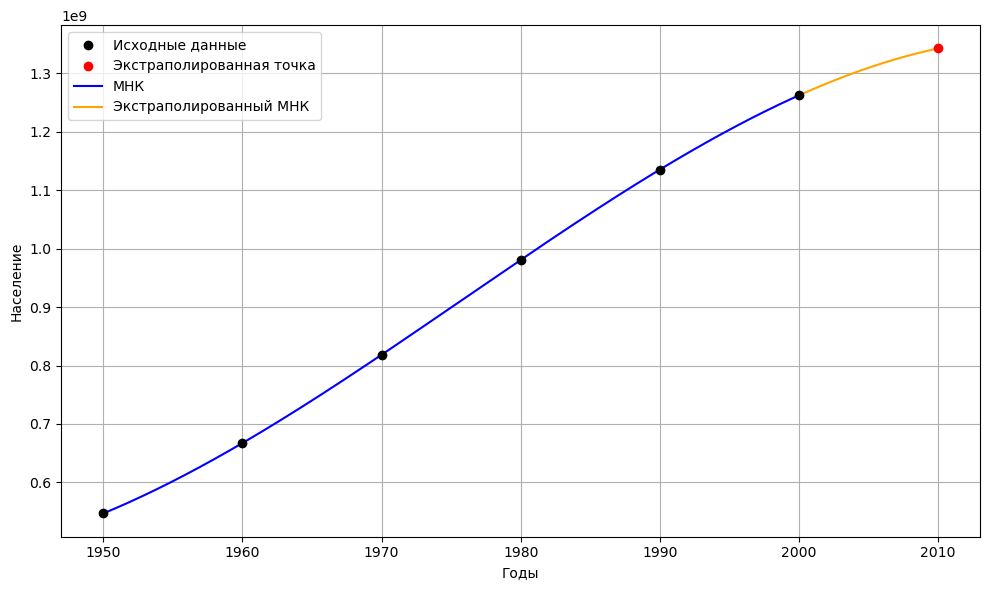

In [249]:
x_ex = np.linspace(2000-np.mean(years), 2010-np.mean(years), 500)
y_ex = polynomial(x_ex, coefficients)
x_ex_orig = x_ex + np.mean(years)

year_ex = 2010
population_2010 = polynomial(year_ex-np.mean(years), coefficients)

plt.figure(figsize=(10, 6))
plt.scatter(years, population, color='black', label='Исходные данные', zorder=3)
plt.scatter(year_ex, population_2010, color='red', label='Экстраполированная точка', zorder=3)
plt.plot(x_original, y_vals, color='blue', label='МНК')
plt.plot(x_ex_orig, y_ex, color='orange', label='Экстраполированный МНК')
plt.xlabel('Годы')
plt.ylabel('Население')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [235]:
print("Экстраполированная точка =", int(population_2010.item()))
print("Экстраполированная точка из графика =", round(y_ex[-1]))

Экстраполированная точка = 1342814999
Экстраполированная точка из графика = 1342815000


**4) Итог**

По данным эксперимента лучше всего население предсказывает МНК и он же лучше всего интерполирует данные (сравнивал по данным населения за 1995 год)
Хотя я ожидал, что лучше всего интерполировать будет сплайн, он тоже очень близок к реальным данным. Возможно из-за того, что мои данные почти линейные, нужно было брать не кубический сплайн, а сплайн более малого порядка